<a href="https://colab.research.google.com/github/engmariamahmed04/NTI-ML-tasks/blob/main/fruit_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/lafifii/Fruit_Recognition.git

Cloning into 'Fruit_Recognition'...
remote: Enumerating objects: 1463, done.
remote: Counting objects: 100% (1159/1159), done.
remote: Compressing objects: 100% (1026/1026), done.
remote: Total 1463 (delta 145), reused 1117 (delta 120), pack-reused 304 (from 1)
Receiving objects: 100% (1463/1463), 62.97 MiB | 34.65 MiB/s, done.
Resolving deltas: 100% (146/146), done.


In [ ]:
#  Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import hog
from skimage.io import imread

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

In [ ]:
IMG_SIZE = 128
BATCH = 32
DATA_DIR = "/content/Fruit_Recognition/FruitsDB"

In [ ]:
#  Load Images using ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())

Found 229 images belonging to 3 classes.
Found 57 images belonging to 3 classes.


In [ ]:
#  HOG Feature Extraction Function

def extract_hog_features(generator):
    features = []
    labels = []

    for batch_imgs, batch_labels in generator:
        for i in range(batch_imgs.shape[0]):
            img = batch_imgs[i]
            img_gray = rgb2gray(img)
            img_resized = resize(img_gray, (64, 64))
            hog_feature = hog(img_resized,
                              orientations=9,
                              pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2),
                              block_norm='L2-Hys',
                              visualize=False)
            features.append(hog_feature)
            labels.append(np.argmax(batch_labels[i]))

        if len(features) >= generator.samples:
            break

    return np.array(features), np.array(labels)


In [ ]:
#  Extract Features

X_train, y_train = extract_hog_features(train_gen)
X_val, y_val = extract_hog_features(val_gen)

print(" X_train:", X_train.shape)
print(" X_val:", X_val.shape)

 X_train: (229, 1764)
 X_val: (57, 1764)


In [ ]:
# Function to Plot Confusion Matrix

def plot_conf_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [ ]:
#  GridSearchCV for each model
# SVM
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svm_grid = GridSearchCV(SVC(), svm_params, cv=3, n_jobs=-1)
svm_grid.fit(X_train, y_train)

#    KNN
knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=3, n_jobs=-1)
knn_grid.fit(X_train, y_train)

#     Decision Tree
dt_params = {
    'max_depth': [None, 5, 10],
    'criterion': ['gini', 'entropy']
}
dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_params, cv=3, n_jobs=-1)
dt_grid.fit(X_train, y_train)

#    Logistic Regression
lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=3, n_jobs=-1)
lr_grid.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'solver': ['lbfgs', 'liblinear']})


 SVM
Accuracy: 94.74%
Classification Report:
              precision    recall  f1-score   support

      Apples       0.90      0.95      0.92        19
     Mangoes       1.00      1.00      1.00        20
     Oranges       0.94      0.89      0.91        18

    accuracy                           0.95        57
   macro avg       0.95      0.95      0.95        57
weighted avg       0.95      0.95      0.95        57

Confusion Matrix:
[[18  0  1]
 [ 0 20  0]
 [ 2  0 16]]


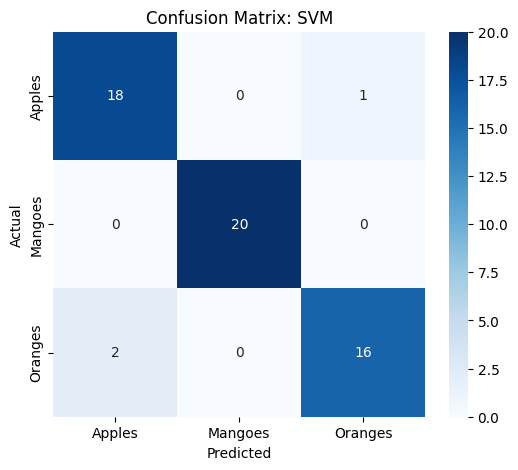


 KNN
Accuracy: 91.23%
Classification Report:
              precision    recall  f1-score   support

      Apples       1.00      0.79      0.88        19
     Mangoes       0.95      1.00      0.98        20
     Oranges       0.81      0.94      0.87        18

    accuracy                           0.91        57
   macro avg       0.92      0.91      0.91        57
weighted avg       0.92      0.91      0.91        57

Confusion Matrix:
[[15  0  4]
 [ 0 20  0]
 [ 0  1 17]]


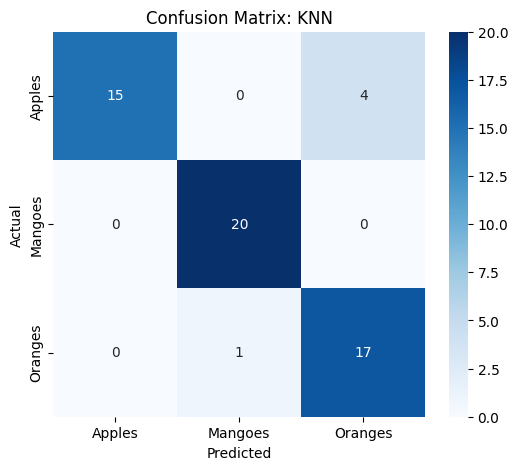


 Decision Tree
Accuracy: 85.96%
Classification Report:
              precision    recall  f1-score   support

      Apples       0.84      0.84      0.84        19
     Mangoes       0.86      0.95      0.90        20
     Oranges       0.88      0.78      0.82        18

    accuracy                           0.86        57
   macro avg       0.86      0.86      0.86        57
weighted avg       0.86      0.86      0.86        57

Confusion Matrix:
[[16  1  2]
 [ 1 19  0]
 [ 2  2 14]]


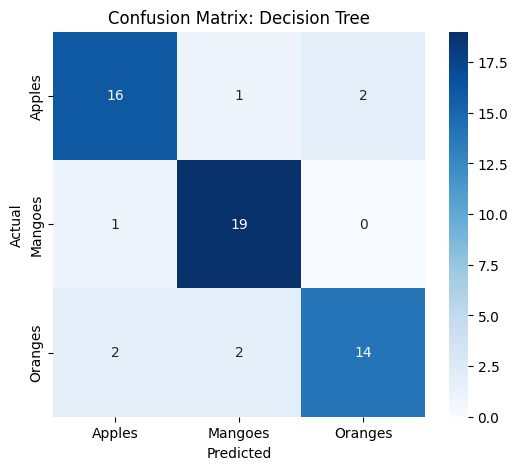


 Logistic Regression
Accuracy: 92.98%
Classification Report:
              precision    recall  f1-score   support

      Apples       0.89      0.89      0.89        19
     Mangoes       0.95      1.00      0.98        20
     Oranges       0.94      0.89      0.91        18

    accuracy                           0.93        57
   macro avg       0.93      0.93      0.93        57
weighted avg       0.93      0.93      0.93        57

Confusion Matrix:
[[17  1  1]
 [ 0 20  0]
 [ 2  0 16]]


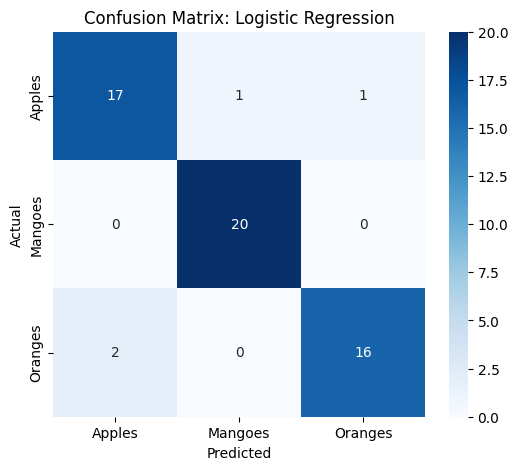

In [ ]:
#  Evaluate Best Models

models = {
    "SVM": svm_grid.best_estimator_,
    "KNN": knn_grid.best_estimator_,
    "Decision Tree": dt_grid.best_estimator_,
    "Logistic Regression": lr_grid.best_estimator_
}

for name, model in models.items():
    print(f"\n {name}")
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred) * 100
    print(f"Accuracy: {acc:.2f}%")
    print("Classification Report:")
    print(classification_report(y_val, y_pred, target_names=class_names))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))
    plot_conf_matrix(y_val, y_pred, labels=class_names, title=name)

In [ ]:
#  Upload Single Image

from google.colab import files
uploaded = files.upload()

Saving OIP (1).jpg to OIP (1).jpg


In [ ]:

#  Preprocess and Predict
def preprocess_single_image(img_path):
    img = imread(img_path)
    img_gray = rgb2gray(img)
    img_resized = resize(img_gray, (64, 64))
    hog_feature = hog(img_resized,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      block_norm='L2-Hys',
                      visualize=False)
    return hog_feature.reshape(1, -1)

img_path = list(uploaded.keys())[0]
img_feature = preprocess_single_image(img_path)

#  Predict using  SVM
pred_class_index = svm_grid.best_estimator_.predict(img_feature)[0]
pred_class_name = class_names[pred_class_index]
print(f" Predicted Class: {pred_class_name}")


 Predicted Class: Apples


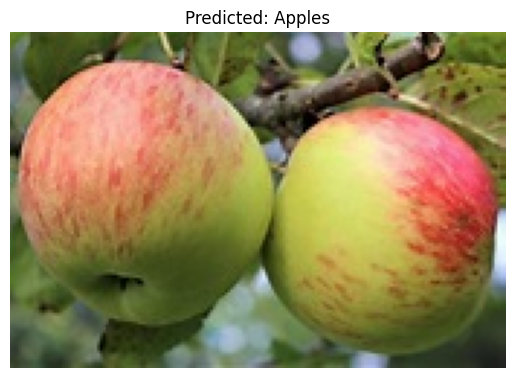

In [ ]:
img_display = imread(img_path)
plt.imshow(img_display)
plt.title(f"Predicted: {pred_class_name}")
plt.axis('off')
plt.show()
